In [6]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
!pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==3.4.2.17 (from versions: 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78)
ERROR: No matching distribution found for opencv-contrib-python==3.4.2.17


In [7]:
import cv2
import os
video_file_path = '/Users/djbautista/anaconda3/envs/cs445_env/Flight_tracking/test_data/Helicopters/tracking/V_HELICOPTER_009.mp4'

cap = cv2.VideoCapture(video_file_path)
output_folder = '/Users/djbautista/anaconda3/envs/cs445_env/Flight_tracking/Frames_3'
os.makedirs(output_folder, exist_ok=True)

frame_count = 606
while True:
    ret, frame = cap.read()
    if not ret:
        break
    output_file_path = os.path.join(output_folder, f'frame_{frame_count:04d}.png')
    cv2.imwrite(output_file_path, frame)
    frame_count += 1
cap.release()

print('Conversion completed.')


[ WARN:0@40.742] global /Users/ec2-user/ci_py311/opencv-suite_1678377996177/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@40.742] global /Users/ec2-user/ci_py311/opencv-suite_1678377996177/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /Users/ec2-user/ci_py311/opencv-suite_1678377996177/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Conversion completed.


In [8]:
def score_projection(pt1, pt2):
    '''
    Score corresponding to the number of inliers for RANSAC
    Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
    Outputs: score (scalar count of inliers) and inliers (1xN logical array)


        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])
    '''
    du = pt2[0] -pt1[0]
    dv = pt2[1] - pt2[1]
    
    inliers = np.sqrt(du**2 + dv**2) < 0.6  # you may need to play with this threshold
    score = sum(inliers)
    
    return score, inliers


def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 4 # Put the correct number of points here

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t

    return H

In [9]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''

    N = pts1.shape[1]
            
    A = np.zeros((2*N, 9))
    for i in range(N):
        A[2*i,:] = [-pts1[0,i],-pts1[1,i],-1,0,0,0,pts1[0,i]*pts2[0,i],pts1[1,i]*pts2[0,i],pts2[0,i]]
        A[2*i+1,:] = [0,0,0,-pts1[0,i],-pts1[1,i],-1,pts1[0,i]*pts2[1,i],pts1[1,i]*pts2[1,i],pts2[1,i]]
    
    H,S,V = svd(A)
    h = V[-1,:]
    
    H = np.reshape(h,(3,3))
    
    return H
    # TO DO

(1000, 4500, 3)


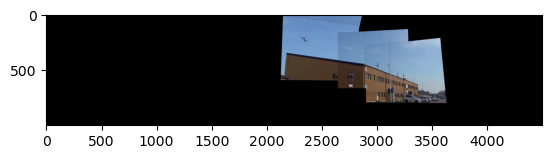

In [13]:
im1 ="/Users/djbautista/anaconda3/envs/cs445_env/Flight_tracking/Frames/frame_0450.png"
im1 = cv2.imread(im1)


key_frames_idx = np.array([190, 210, 350, 490, 630])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("/Users/djbautista/anaconda3/envs/cs445_env/Flight_tracking/Frames/frame_0{num}.png".format(num=str(key_frames_idx[n]+1).zfill(3)))

H_12 = auto_homography(frames[0],frames[1], computeHomography)
H_23 = auto_homography(frames[1],frames[2], computeHomography)
H_34 = auto_homography(frames[3],frames[2], computeHomography)
H_45 = auto_homography(frames[4],frames[3], computeHomography)
transformation_matrix = np.array([[1, 0, 2500], [0, 1, 90], [0, 0, 1]])

warped_image_13 = cv2.warpPerspective(frames[0], transformation_matrix.dot(H_12 @ H_23), (4500, 1000))
warped_image_23 = cv2.warpPerspective(frames[1], transformation_matrix.dot(H_23), (4500, 1000))
warped_image_34 = cv2.warpPerspective(frames[3], transformation_matrix.dot(H_34), (4500, 1000))
warped_image_35 = cv2.warpPerspective(frames[4], transformation_matrix.dot(H_34@H_45), (4500, 1000))
warps=[warped_image_13, warped_image_23, warped_image_34, warped_image_35]

blended = warped_image_13
for i in range(len(warps)-1):
  mask =  warps[i+1]!= 0
  blended = blended*(1-mask)
  blended= blended+warps[i+1]
print(blended.shape)
blended_1 = blended.astype(np.uint8)
plt.imshow(blended_1[:,:,[2,1,0]])



(1000, 4500, 3)


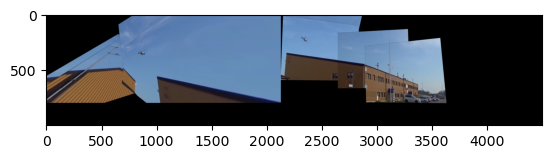

In [14]:
im1 ="/Users/djbautista/anaconda3/envs/cs445_env/Flight_tracking/Frames/frame_0450.png"
im1 = cv2.imread(im1)


key_frames_idx = np.array([130, 140, 150, 160, 170])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("/Users/djbautista/anaconda3/envs/cs445_env/Flight_tracking/Frames/frame_0{num}.png".format(num=str(key_frames_idx[n]+1).zfill(3)))

H_12 = auto_homography(frames[0],frames[1], computeHomography)
H_23 = auto_homography(frames[1],frames[2], computeHomography)
H_34 = auto_homography(frames[3],frames[2], computeHomography)
H_45 = auto_homography(frames[4],frames[3], computeHomography)
transformation_matrix = np.array([[1, 0, 650], [0, 1, 90], [0, 0, 1]])

warped_image_13 = cv2.warpPerspective(frames[0], transformation_matrix.dot(H_12 @ H_23), (4500, 1000))
warped_image_23 = cv2.warpPerspective(frames[1], transformation_matrix.dot(H_23), (4500, 1000))
warped_image_34 = cv2.warpPerspective(frames[3], transformation_matrix.dot(H_34), (4500, 1000))
warped_image_35 = cv2.warpPerspective(frames[4], transformation_matrix.dot(H_34@H_45), (4500, 1000))
warps=[warped_image_13, warped_image_23, warped_image_34, warped_image_35]

blended = warped_image_13
for i in range(len(warps)-1):
  mask =  warps[i+1]!= 0
  blended = blended*(1-mask)
  blended= blended+warps[i+1]
print(blended.shape)

blended = blended.astype(np.uint8)
for x in range(len(blended)):
  for y in range(len(blended[0])):
    if x>800 or y>2130:
      blended[x,y]=[0,0,0]
new_blend = blended[:,:,[2,1,0]]+blended_1[:,:,[2,1,0]]
plt.imshow(blended[:,:,[2,1,0]]+blended_1[:,:,[2,1,0]])



In [15]:

non_black_indices = np.where((new_blend != [0, 0, 0]).all(axis=-1))

min_y, min_x = np.min(non_black_indices, axis=1)
max_y, max_x = np.max(non_black_indices, axis=1)

colored_part = new_blend[min_y:max_y, min_x:max_x, :]
new_image = np.zeros_like(new_blend)
shift_amount = 800
shift_amount = min(shift_amount, new_blend.shape[1] - colored_part.shape[1])
new_image[min_y:max_y, shift_amount:shift_amount + colored_part.shape[1], :] = colored_part


(1000, 4500, 3)


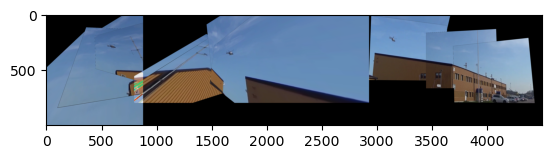

In [16]:
im1 ="/Users/djbautista/anaconda3/envs/cs445_env/Flight_tracking/Frames/frame_0450.png"
im1 = cv2.imread(im1)


key_frames_idx = np.array([45, 55, 65, 75, 90])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("/Users/djbautista/anaconda3/envs/cs445_env/Flight_tracking/Frames/frame_0{num}.png".format(num=str(key_frames_idx[n]+1).zfill(3)))

H_12 = auto_homography(frames[0],frames[1], computeHomography)
H_23 = auto_homography(frames[1],frames[2], computeHomography)
H_34 = auto_homography(frames[3],frames[2], computeHomography)
H_45 = auto_homography(frames[4],frames[3], computeHomography)
transformation_matrix = np.array([[1, 0, 300], [0, 1, 90], [0, 0, 1]])

warped_image_13 = cv2.warpPerspective(frames[0], transformation_matrix.dot(H_12 @ H_23), (4500, 1000))
warped_image_23 = cv2.warpPerspective(frames[1], transformation_matrix.dot(H_23), (4500, 1000))
warped_image_34 = cv2.warpPerspective(frames[3], transformation_matrix.dot(H_34), (4500, 1000))
warped_image_35 = cv2.warpPerspective(frames[4], transformation_matrix.dot(H_34@H_45), (4500, 1000))
warps=[warped_image_13, warped_image_23, warped_image_34, warped_image_35]

blended = warped_image_13
for i in range(len(warps)-1):
  mask =  warps[i+1]!= 0
  blended = blended*(1-mask)
  blended= blended+warps[i+1]
print(blended.shape)
blended = blended.astype(np.uint8)
for x in range(len(blended)):
  for y in range(len(blended[0])):
    if y>880:
      blended[x,y]=[0,0,0]
combined=blended[:,:,[2,1,0]]+new_image
plt.imshow(combined)



In [17]:
import os 
dir_frames = '/Users/djbautista/anaconda3/envs/cs445_env/Flight_tracking/Frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".png")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.imread(file_i)


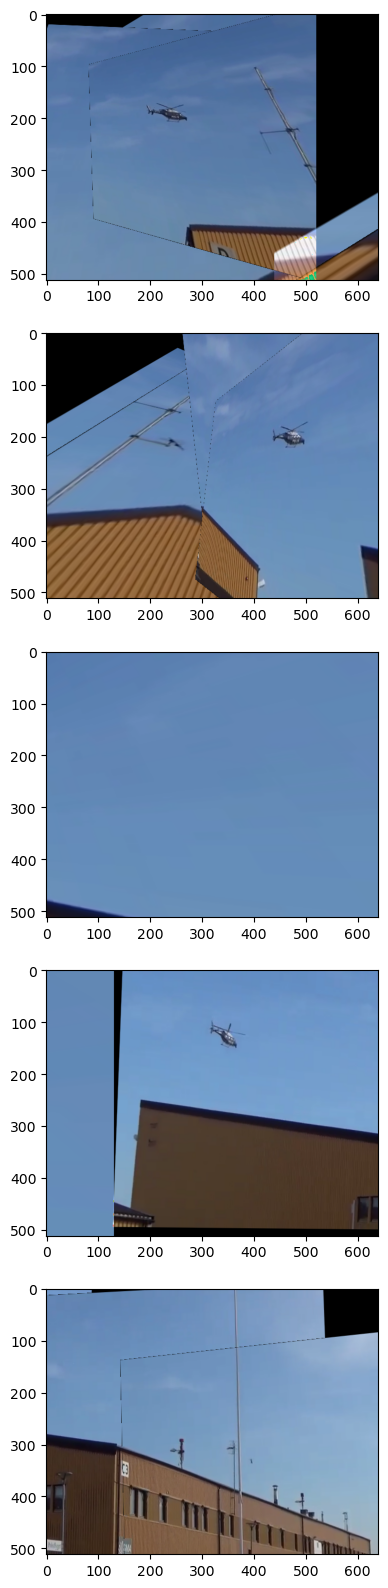

In [18]:
fig, ax = plt.subplots(5, figsize=(20, 20))
pt1=combined[100:612,360:1000,:]
ax[0].imshow(pt1)
pt2=combined[150:662,1200:1840,:]
ax[1].imshow(pt2)
pt3=combined[100:612,1900:2540,:]
ax[2].imshow(pt3)
pt4=combined[100:612,2800:3440,:]
ax[3].imshow(pt4)
pt5=combined[150:662,3550:4190,:]
ax[4].imshow(pt5)

In [19]:
import onnxruntime
import numpy as np
from PIL import Image
def detect_object(image):
    model_path = '/Users/djbautista/anaconda3/envs/cs445_env/Flight_tracking/yolov2_ex.onnx'
    session = onnxruntime.InferenceSession(model_path)

    image = image.transpose((2, 0, 1)) 
    image = np.expand_dims(image, axis=0).astype(np.float32) / 255.0  
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    result = session.run([output_name], {input_name: image})

    bboxes, scores, labels = result[0][:, :4], result[0][:, 4], result[0][:, 5:]
    return bboxes, scores, labels

ModuleNotFoundError: No module named 'onnxruntime'

In [50]:
bboxes1, scores1, labels1 = detect_object(pt1)
bboxes2, scores2, labels2 = detect_object(pt2)
bboxes3, scores3, labels3 = detect_object(pt3)
bboxes4, scores4, labels4 = detect_object(pt4)
bboxes5, scores5, labels5 = detect_object(pt5)
x=[0]*5
y=[0]*5
width =[0]*5
height=[0]*5
label=['NA']*5

x[0], y[0], width[0], height[0] = bboxes1[np.argmax(scores1)]
x[0]+=360
y[0]+= 100
labels[0] =labels1[np.argmax(scores1)] 
x[1], y[1], width[1], height[1] = bboxes2[np.argmax(scores2)]
x[1]+= 1200
y[1]+=  150  
labels[1] =labels2[np.argmax(scores2)] 
x[2], y[2], width[2], height[2] = bboxes3[np.argmax(scores3)]
x[2]+= 1900
y[2]+= 100
labels[2] =labels3[np.argmax(scores3)] 
x[3], y[3], width[3], height[3] = bboxes4[np.argmax(scores4)]
x[3]+= 2800
y[3]+= 100   
labels[3] =labels4[np.argmax(scores4)] 
x[4], y[4], width[4], height[4] = bboxes5[np.argmax(scores5)]
x[4]+= 3550
y[4]+= 150   
labels[4] =labels5[np.argmax(scores5)] 

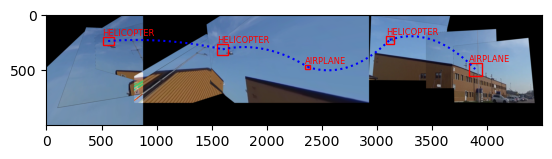

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d

def draw_labeled_bboxes_with_curved_trajectory(image_array, x, y, width, height, labels, trajectory_color='b'):
    fig, ax = plt.subplots()
    ax.imshow(image_array)
    prev_center_x, prev_center_y = None, None

    for i in range(len(x)):
        bbox = patches.Rectangle((x[i], y[i]), width[i], height[i], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(bbox)

        plt.text(x[i], y[i] - 10, labels[i], color='r', fontsize=6)

        center_x = x[i] + width[i] / 2
        center_y = y[i] + height[i] / 2

        if prev_center_x is not None and prev_center_y is not None:
            control_points_x = [prev_center_x, (prev_center_x + center_x) / 2, center_x]
            control_points_y = [prev_center_y, prev_center_y, center_y]
            
            t = np.linspace(0, 1, 100)
            x_curve = interp1d([0, 0.5, 1], control_points_x, kind='quadratic')(t)
            y_curve = interp1d([0, 0.5, 1], control_points_y, kind='quadratic')(t)

            ax.plot(x_curve, y_curve, linestyle='dotted', color=trajectory_color)
        prev_center_x, prev_center_y = center_x, center_y

    plt.savefig('output_fin.png')
    plt.show()

combined_c =combined
draw_labeled_bboxes_with_curved_trajectory(combined_c, x, y, width, height, label)
